In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Conv2D, Flatten, Dense, LSTM, ConvLSTM2D, \
    MaxPooling2D, GRU
from keras.models import Sequential
from common import extract_training_data

IMAGE_SIZE = (64, 64, 3)

In [4]:
images, labels = extract_training_data("Data/20171029-201949.h264.avi", "Data/20171029-201949.h264.csv", IMAGE_SIZE)
y_train = labels.as_matrix(columns=labels.columns[1: -1])
y_train.shape

(1744, 3)

# 2D-Conv GRU network

In [3]:
from keras.layers import Permute, Reshape

def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Permute((3, 2, 1)))
    model.add(Reshape((4, 7688)))
    model.add(GRU(64, return_sequences=False))
    model.add(Dense(3, activation='linear'))

    model.compile(loss="mse", optimizer="adam")
    
    return model

model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
permute_1 (Permute)          (None, 32, 31, 31)        0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 7688)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                1488576   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 1,489,667
Trainable params: 1,489,667
Non-trainable params: 0
_________________________________________________________________


In [5]:
history = model.fit(images, y_train, batch_size=64, epochs=10, validation_split=0.04)

Train on 1674 samples, validate on 70 samples
Epoch 1/10
1674/1674 [==============================] - 13s - loss: 1.0028 - val_loss: 0.2669
Epoch 2/10
1674/1674 [==============================] - 12s - loss: 0.0878 - val_loss: 0.2666
Epoch 3/10
1674/1674 [==============================] - 15s - loss: 0.0664 - val_loss: 0.2665
Epoch 4/10
1674/1674 [==============================] - 12s - loss: 0.0550 - val_loss: 0.2714
Epoch 5/10
1674/1674 [==============================] - 11s - loss: 0.0492 - val_loss: 0.2753
Epoch 6/10
1674/1674 [==============================] - 12s - loss: 0.0452 - val_loss: 0.3005
Epoch 7/10
1674/1674 [==============================] - 14s - loss: 0.0412 - val_loss: 0.2633
Epoch 8/10
1674/1674 [==============================] - 13s - loss: 0.0386 - val_loss: 0.2753
Epoch 9/10
1674/1674 [==============================] - 14s - loss: 0.0348 - val_loss: 0.3357
Epoch 10/10
1674/1674 [==============================] - 12s - loss: 0.0342 - val_loss: 0.3004


In [6]:
test_images, test_labels = extract_training_data("Data/20171029-201639.h264.avi", 
                                                            "Data/20171029-201639.h264.csv", 
                                                            IMAGE_SIZE)

prediction = model.predict(test_images)

In [7]:
prediction

array([[ 0.35487324,  0.04773247,  0.97633666],
       [ 0.36069515,  0.07747481,  0.9662829 ],
       [ 0.34121108,  0.06810095,  0.97056681],
       ..., 
       [-0.20059229, -0.0848408 ,  0.95851427],
       [-0.31776491,  0.00480125,  1.04068553],
       [-0.12902276, -0.01198367,  0.9342581 ]], dtype=float32)

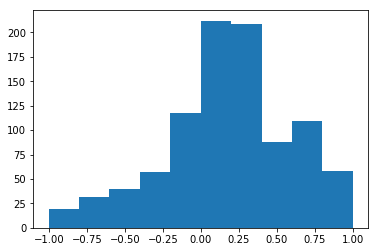

In [8]:
plt.hist(prediction[:, 0])
plt.show()

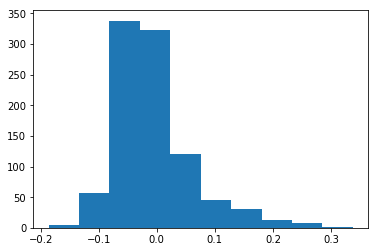

In [9]:
plt.hist(prediction[:, 1])
plt.show()

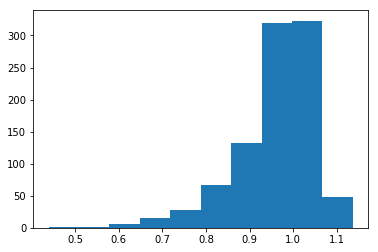

In [10]:
plt.hist(prediction[:, 2])
plt.show()

In [11]:
validation_labels = test_labels.as_matrix(columns=test_labels.columns[1: -1])
clipped_prediction = np.zeros_like(prediction)

clipped_prediction[:, 0] = np.clip(prediction[:, 0], -1, 1)
clipped_prediction[:, 1] = np.clip(prediction[:, 1], 0, 1)
clipped_prediction[:, 2] = np.clip(prediction[:, 2], 0, 1)

print(validation_labels.shape)
print(clipped_prediction.shape)

(942, 3)
(942, 3)


In [12]:
from sklearn.metrics import explained_variance_score
explained_variance_score(validation_labels, prediction)

0.087111365515878725

# K fold cross-validation

In [13]:
from common import run_kfold_cross_val

# Concatenate both videos
total_images = np.concatenate((images, test_images), axis=0)
total_labels = np.concatenate((labels, test_labels), axis=0)

total_y_train = total_labels[:, 1:-1]

results = run_kfold_cross_val(create_model, total_images, total_y_train)
print(results)
print(results.mean())
print(np.median(results))

[  1.36788270e-03   1.53433192e-02   1.81131124e-01   2.28401750e-01
   2.55362328e-01  -2.07300035e-08   1.60449410e-01   2.16351104e-01
   4.66106240e-02   6.50884222e-02]
0.117010594384
0.112768916225


# Save the model

In [14]:
from keras.models import load_model

model.save('gru.h5')
del model
model = load_model('gru.h5')